## 언어 모델을 사용한 문장 생성

#### 문장 생성 구현

In [1]:
%cd /content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝2

/content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝2


In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids = None, sample_size = 100):
    word_ids = [start_id]

    x = start_id
    while len(word_ids) < sample_size:
      x = np.array(x).reshpae(1, 1)
      score = self.predict(x)
      p = softmax(score.flatten())

      sampled = np.random.choice(len(p), size = 1, p=p)
      if (skip_ids is None) or (sampled not in skip_ids):
        x = sampled
        word_ids.append(int(x))
    
    return word_ids

In [3]:
import sys
sys.path.append('..')
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
# model.load_params('../ch06/Rnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you she volokh relax diplomats sci brand productive complete initially prefers studio barely vax obtaining wages truce smooth diplomat inefficient brady generous deb ground savaiko par seasonal competes starts dresdner carolina deadly moving journalism petrie fortune spouse n.y intensify modify having woes springs lock mafia kelly nebraska stop-loss premium barclays story hope coup purchases exploration manpower gerald largest coming newly ship eventual affecting workstation greed exhibit adults punishment gets disciplinary soap bells dressed shannon cutting channels omitted aboard element table roughly opposition federated uncovered punishable speed with discrimination n.v processed comsat bobby program indicating legislator specifications properties decisive tribe tours


In [4]:
# 6장에서 학습한 가중치 매개변수 읽어 들임
import sys
sys.path.append('..')
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./ch06/Rnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you think is meeting in december with those strength he will give sell boys as taxes was n't trying to find.
 the coffee forces would spur wonder whether they could just give much large consumer barriers.
 like the lawmakers ' union shows that total further cuts in a unexpected it would climb to twice match the chain.
 some a few days the largest note will be able to increase rates to u.s. tucson atlantic resources to corporations or buying investment value in the funds and even in tokyo 's strength contributed to the market 's managers malignant


## seq2seq

#### 덧셈 데이터셋

In [5]:
import sys
sys.path.append('..')
from dataset import sequence

(x_train, t_train), (x_test, t_test) =  sequence.load_data('addition.txt', seed = 220203)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  2 11  9  1  5  5]
[ 6 11  0 10  5]
7+806  
_813 


## seq2seq 구현

#### Encoder 클래스

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4 * H).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = False)

    self.params = self.embed.params + self.lstm.params
    self.grads = self.embed.grads + self.lstm.grads
    self.hs = None

  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return hs[:, -1, :]

  def backward(self, dh):
    dhs = np.zeors_like(self.hs)
    dhs[:, -1, :] = dh
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

#### Decoder 클래스

In [7]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Decoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4 * H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = False)
    self.affine = TimeAffine(affine_W, affine_b)

    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, h):
    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    out = self.lstm.forward(out)
    score = self.affine.forward(out)
    return out

  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    dout = self.lstm.backward(dout)
    dout = self.embed.backward(dout)
    dh = self.lstm.dh
    return dh

  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array(sample_id).reshape((1, 1))
      out = self.embed.forward(x)
      out = self.lstm.forward(out)
      score = self.affine.forward(out)

      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))

    return sampled

#### Seq2seq 클래스

In [8]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Seq2seq(BaseModel):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = Decoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

  def forward(self, xs, ts):
    decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
    h = self.encoder.forward(xs)
    score = self.decoder.forward(decoder_xs, h)
    loss = self.softmax.forward(score, decoder_ts)
    return loss

  def backward(self, dout = 1):
    dout = self.softmax.backward(dout)
    dh = self.decoder.backward(dout)
    dout = self.encoder.backward(dh)
    return dout

  def generate(self, xs, start_id, sample_size):
    h = self.encoder.forward(xs)
    sampled = self.decoder.generate(h, start_id, sample_size)
    return sampled

#### seq2seq 평가

seq2seq의 학습은 기본적인 신경망의 학습과 같은 흐름으로 이뤄집니다.
1. 학습 데이터에서 미니배치를 선택하고,
2. 미니배치로부터 기울기를 계산하고,
3. 기울기를 사용하여 매개변수를 갱신한다.

In [9]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch = 1,
              batch_size = batch_size, max_grad = max_grad)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)

  print(f'검증 정확도: {acc * 100:.3f}%')

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 8[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 9[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 10[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 16[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 17[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 19[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 20[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 21[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 23[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
--

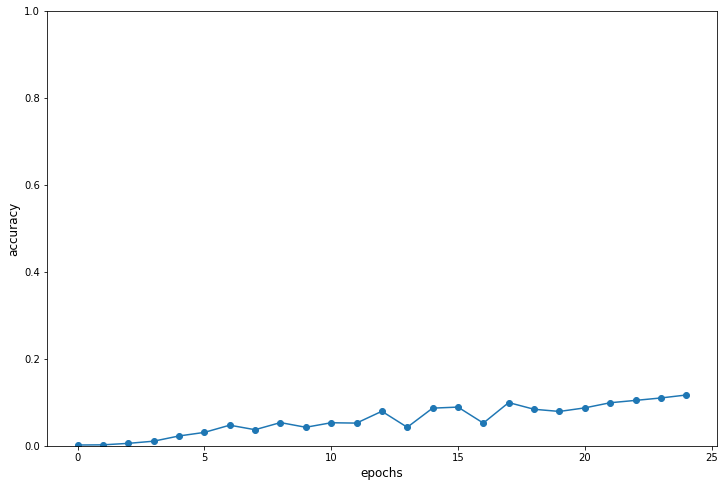

In [10]:
x = np.arange(len(acc_list))
plt.figure(figsize = (12,8))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.ylim(0, 1.0)
plt.show()

## seq2seq 개선

#### 입력 데이터 반전(Reversed)

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 8[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 9[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 10[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 12[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 13[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 15[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 16[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 19[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 20[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 21[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 23[s] | 손실 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1000
---
Q  48+285
T 666 
☒ 1001
---
Q   551+8
T 163 
☒ 100 
---
Q  55+763
T 422 
☒ 1001
---
Q 752+006
T 857 
☒ 1000
---
Q 292+167
T 1053
☒ 1000
---
Q 795+038
T 1427
☒ 1000
--

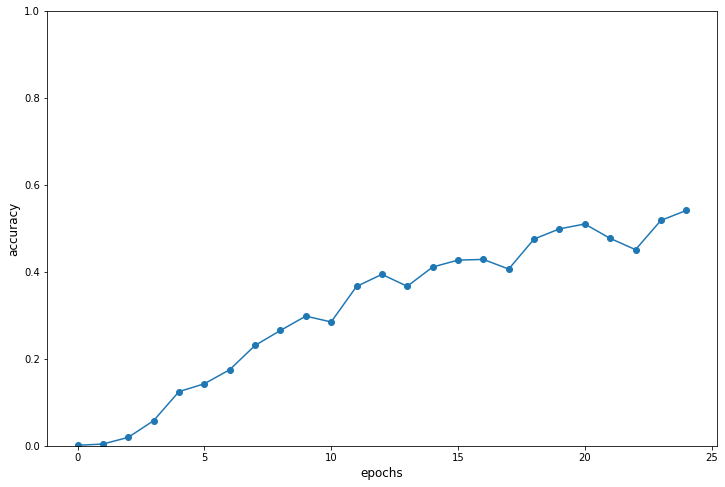

In [11]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch = 1,
              batch_size = batch_size, max_grad = max_grad)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)

  print(f'검증 정확도: {acc * 100:.3f}%')

x = np.arange(len(acc_list))
plt.figure(figsize = (12,8))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.ylim(0, 1.0)
plt.show()

#### 엿보기(Peeky)

In [13]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Seq2seq, Encoder

class PeekyDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
    lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4 * H).astype('f')
    affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = False)
    self.affine = TimeAffine(affine_W, affine_b)

    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads
    self.cache = None
  
  def forward(self, xs, h):
    N, T = xs.shape
    N, H = h.shape

    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    hs = np.repeat(h, T, axis = 0).reshape(N, T, H)
    out = np.concatenate((hs, out), axis = 2)

    out = self.lstm.forward(out)
    out = np.concatenate((hs, out), axis = 2)

    score = self.affine.forward(out)
    self.cache = H
    return score


  def backward(self, dscore):
    H = self.cache

    dout = self.affine.backward(dscore)
    dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
    dout = self.lstm.backward(dout)
    dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
    self.embed.backward(dembed)

    dhs = dhs0 + dhs1
    dh = self.lstm.dh + np.sum(dhs, axis = 1)
    return dh

  def generate(self, h, start_id, sample_size):
    sampled = []
    char_id = start_id
    self.lstm.set_state(h)

    H = h.shape[1]
    peeky_h = h.reshape(1, 1, H)
    for _ in range(sample_size):
      x = np.array(char_id).reshape((1, 1))
      out = self.embed.forward(x)

      out = np.concatenate((peeky_h, out), axis = 2)
      out = self.lstm.forward(out)
      out = np.concatenate((peeky_h, out), axis = 2)
      score = self.affine.forward(out)

      char_id = np.argmax(score.flatten())
      sampled.append(int(char_id))

    return sampled

In [14]:
from ch07.seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = PeekyDecoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 4[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 5[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 8[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 9[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 11[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 12[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 14[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 16[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 18[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 19[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 21[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 22[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 23[s] | 손실 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1013
---
Q  48+285
T 666 
☒ 102 
---
Q   551+8
T 163 
☒ 100 
---
Q  55+763
T 422 
☒ 1023
---
Q 752+006
T 857 
☒ 1023
---
Q 292+167
T 1053
☒ 1023
---
Q 795+038
T 1427
☒ 1111
--

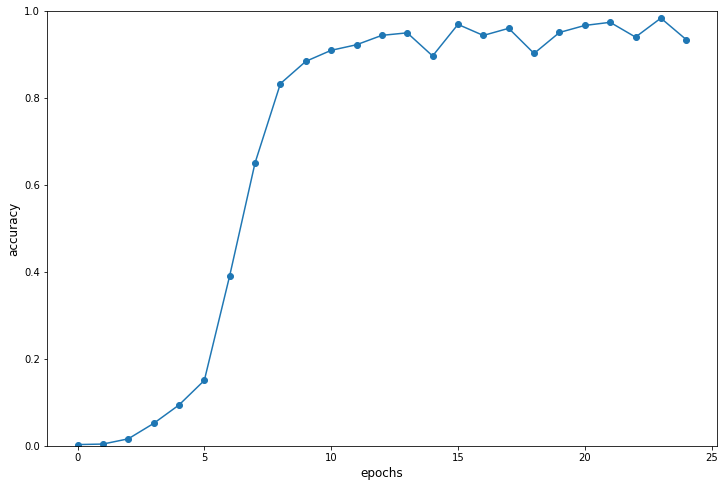

In [15]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch = 1,
              batch_size = batch_size, max_grad = max_grad)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)

  print(f'검증 정확도: {acc * 100:.3f}%')

x = np.arange(len(acc_list))
plt.figure(figsize = (12,8))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.ylim(0, 1.0)
plt.show()

## 정리

- RNN을 이용한 언어 모델은 새로운 문장을 생성할 수 있다.
- 문장을 생성할 때는 하나의 단어(혹은 문자)를 주고 모델의 출력(확률분포)에서 샘플링하는 과정을 반복한다.
- RNN을 2개 조합함으로써 시계열 데이터를 다른 시계열 데이터로 변환할 수 있다.
- seq2seq는 Enocder가 출발어 입력문을 인코딩하고, 인코딩된 정보를 Decoder가 받아 디코딩하여 도착어 출력문을 얻는다.
- 입력문을 반전시키는 기번(Reverse), 또는 인코딩된 정보를 Decoder의 여러 계층에 전달하는 기법(Peeky)은 seq2seq의 정확도 향상에 효과적인다.
- 기계 번역, 챗봇, 이미지 캡셔닝 등 seq2seq는 다양한 애플리케이션에 이용할 수 있다.